<a href="https://colab.research.google.com/github/JennGuz/4GeeksAcademy/blob/master/project_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [66]:
# standard libraries
import regex as re

# data processing
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# display
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# natural language processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Kaggle (dataset download)
import kagglehub

# Required downloads for nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

# Download the dataset with KaggleHub
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
print("Path to dataset files:", path)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


# Loading the dataset

In [67]:
df = pd.read_csv(path + '/Combined Data.csv', index_col=0)
df_02 = df.copy()
df_02.sample(10)

,statement,status
38737,i ve literally never changed my hairstyle it s...,Depression
46669,"Wrote this while sectioned , day 6... ""Mania M...",Bipolar
44484,suck when you know you haven t done anything w...,Normal
46384,Will You Take Medications For The Rest of Your...,Bipolar
50022,NaN,Bipolar
45574,"Stem cell research When you are bipolar, have ...",Bipolar
2443,Brinqs 'žðŸ'–ðŸ'—ðŸ'—ðŸ'—ðŸ'—ðŸ'—ðŸ'—,Normal
7355,i feel like i ruined everyone is lives. and no...,Suicidal
13969,A natural death strikes me as much worse than ...,Suicidal
26279,I have known this girl for years and we got to...,Depression


In [68]:
df_02.shape

(53043, 2)

In [69]:
df_02 = df_02.drop(df_02[df_02["statement"].str.len() <= 4].index)
df_02.shape

(52997, 2)

In [70]:
df_02.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52997 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52635 non-null  object
 1   status     52997 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [71]:
df_02.isnull().sum()

,0
statement,362
status,0


In [72]:
df_02.dropna(inplace=True)
df_02.isnull().sum()

,0
statement,0
status,0


In [73]:
df_02.duplicated().sum()

1576

In [74]:
df_02.drop_duplicates(inplace=True)
df_02.duplicated().sum()

0

In [75]:
df_02.describe()

,statement,status
count,51059,51059
unique,51039,7
top,#NAME?,Normal
freq,4,16007


Text(0.5, 1.0, 'Distribution of Mental Health Statuses')

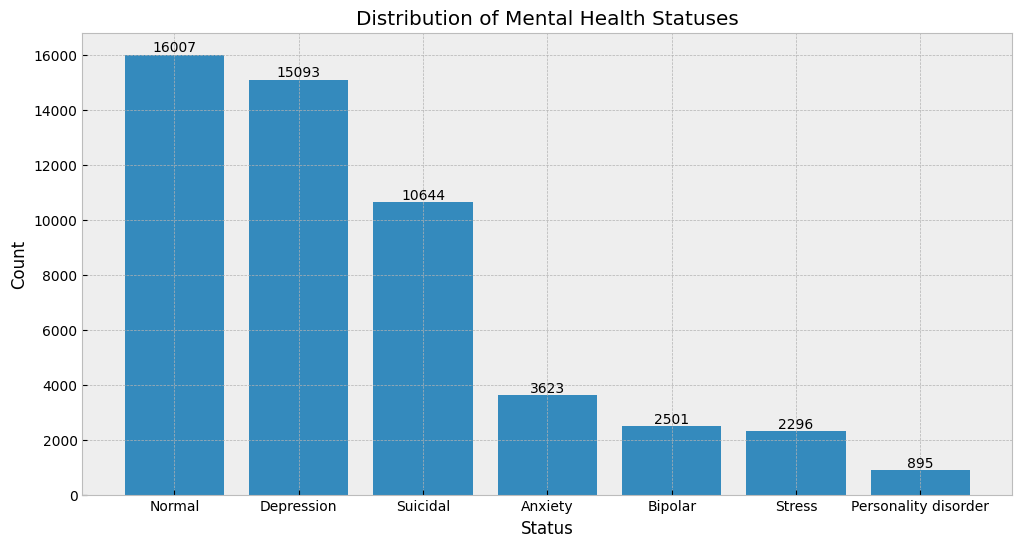

In [76]:
plt.figure(figsize=(12, 6))
status_counts = df_02['status'].value_counts()
plt.style.use("bmh")

for i, v in enumerate(status_counts):
  plt.text(i, v, str(v), ha='center', va='bottom')

plt.bar(status_counts.index, status_counts.values)
plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Distribution of Mental Health Statuses')

In [77]:
def preprocess_text(text):

    # convert text to lowercase
    text = str(text).lower()

    # removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # removing any text that starts with @
    text = re.sub(r'@\S+', '', text)

    # removing any text that starts with #
    text = re.sub(r'#\S+', '', text)

    # removing words that contain numbers
    text = re.sub(r'\w*\d\w*', '', text)

    # removing extra spaces
    text = re.sub(r'\s+', ' ', text)

    # removing line breaks
    text = re.sub(r'\n', ' ', text)

    # removing punctuations marks
    text = re.sub(r'[^\w\s]', '', text)

    # tokenization
    tokens = word_tokenize(text)

    # filter stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # joining the tokens back into a chain
    text = ' '.join(tokens)

    return text.split()

In [78]:
df_02['text_clean'] = df_02['statement'].apply(preprocess_text)
df_02.sample(10)

,statement,status,text_clean
4772,"If you protest, you need to invite all mass e-...",Normal,"[protest, need, invite, mass, emails, cb, prov..."
24202,I do not really know what I am supposed to say...,Suicidal,"[really, know, supposed, say, keep, waiting, b..."
3425,ba! aliceeu mutualann yukðŸ˜³ rt/like ajaa ava...,Normal,"[ba, aliceeu, mutualann, yukðÿ, rtlike, ajaa, ..."
10608,Feeling suicidal and actively depressed. But i...,Depression,"[feeling, suicidal, actively, depressed, ask, ..."
29152,"on to friends, I recently moved into my first ...",Stress,"[friends, recently, moved, first, apartment, c..."
3165,"When I was in the marathon for drakor, au, wha...",Normal,"[marathon, drakor, au, whattpad, others, vent,..."
5063,the bc definitely hasn't taken a showerðŸš¶â€ â™€,Normal,"[bc, definitely, hasnt, taken, showerðÿšâ, â]"
25448,"Just to make it clear, I am not going to divul...",Depression,"[make, clear, going, divulge, anything, person..."
36994,@micheal25 Have a great day back at ya,Normal,"[great, day, back, ya]"
23458,I am a student and work part-time.Today my pro...,Depression,"[student, work, parttimetoday, professor, scol..."


In [79]:
lematizer = WordNetLemmatizer()

def lemmatize_text(tokens):
    lemmatized_tokens = [lematizer.lemmatize(token, pos="v") for token in tokens]
    return ' '.join(lemmatized_tokens)

df_02['text_lematized'] = df_02['text_clean'].apply(lemmatize_text)
df_02.sample(10)

,statement,status,text_clean,text_lematized
48776,These headaches don't go away when they come o...,Stress,"[headaches, dont, go, away, come, stress, feel...",headaches dont go away come stress feel great ...
9070,I am so fucking tried. Every time I think I mi...,Suicidal,"[fucking, tried, every, time, think, might, mo...",fuck try every time think might moderately bet...
17022,I have (had?) severe eczema since I was a chil...,Suicidal,"[severe, eczema, since, child, past, spring, r...",severe eczema since child past spring really k...
41134,denismcmichael thakre aarya stats feed and tha...,Depression,"[denismcmichael, thakre, aarya, stats, feed, c...",denismcmichael thakre aarya stats fee country ...
9604,"Every day at some point, at least once, my bra...",Depression,"[every, day, point, least, brain, reminds, wea...",every day point least brain remind weak much f...
22123,I feel sick to my stomach. I cannot talk at al...,Depression,"[feel, sick, stomach, talk, barely, energy, mo...",feel sick stomach talk barely energy move look...
46113,Went on 2mg Abilify exactly 7 days ago as of t...,Bipolar,"[went, abilify, exactly, days, ago, today, ive...",go abilify exactly days ago today ive gain pou...
32509,i'll say. my girlfriend has a nose like a drug...,Normal,"[ill, say, girlfriend, nose, like, drug, dog]",ill say girlfriend nose like drug dog
42721,haha i ve been with my grandma for day even sh...,Normal,"[haha, grandma, day, even, house, away, still,...",haha grandma day even house away still miss
14891,I just cannot live my life anymore. Every day ...,Depression,"[live, life, anymore, every, day, struggle, tr...",live life anymore every day struggle try make ...


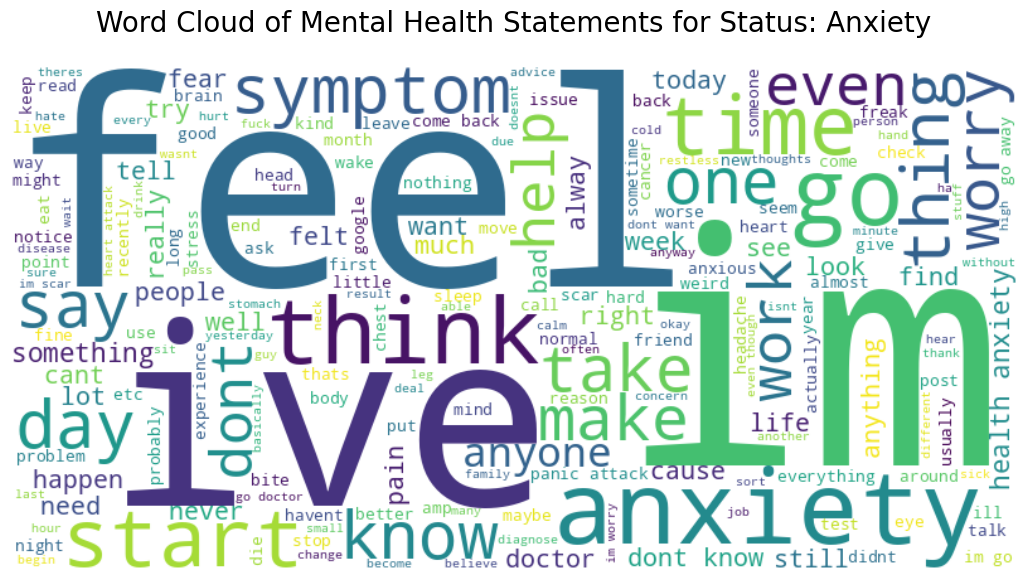

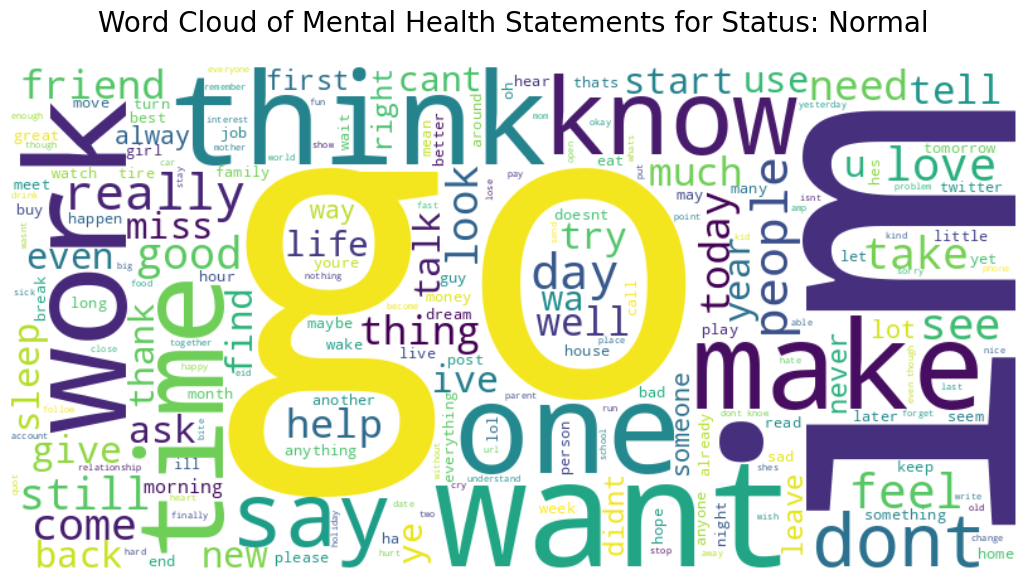

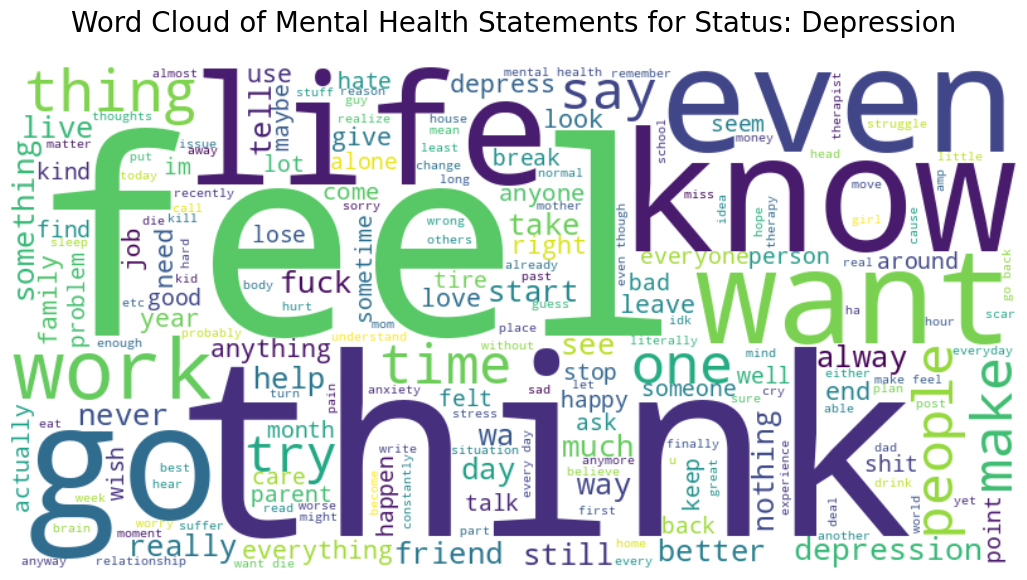

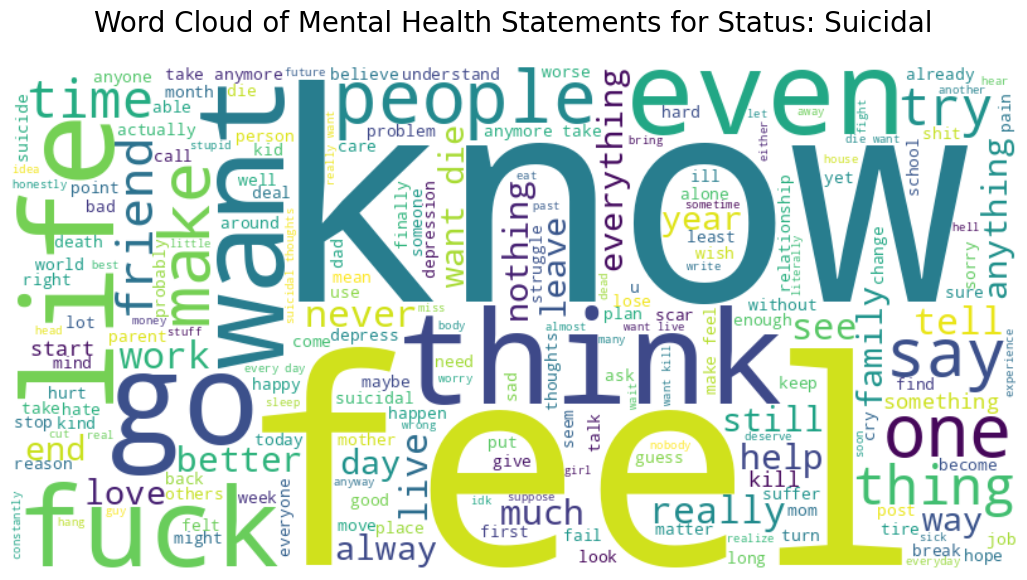

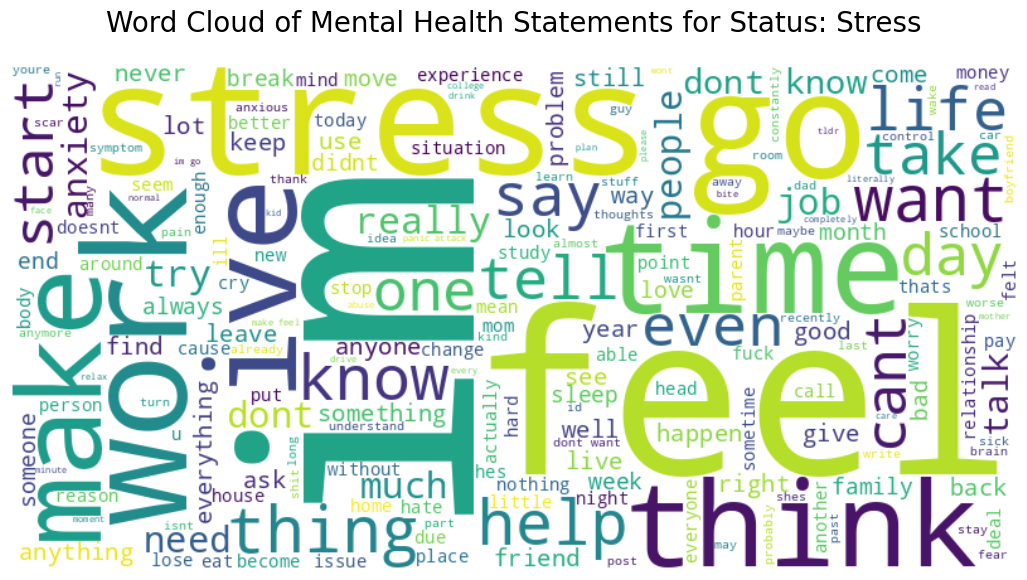

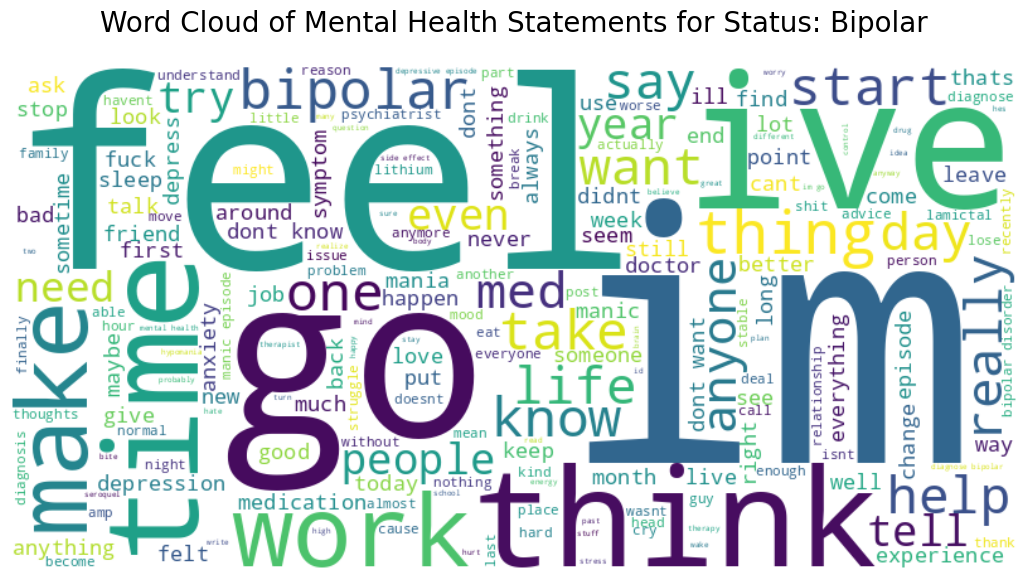

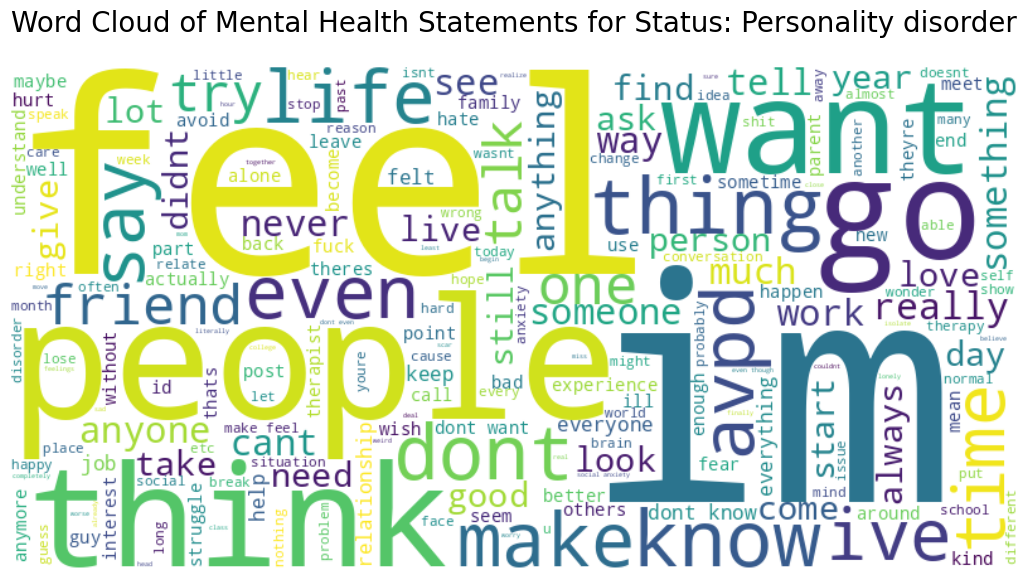

In [80]:
statuses = df_02['status'].unique()

for status in statuses:
    filtered_df = df_02[df_02['status'] == status]

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_df['text_lematized']))

    plt.figure(figsize=(13, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Mental Health Statements for Status: {status}', fontsize=20, pad=25)
    plt.show()


In [81]:
label_encoder = LabelEncoder()

df_02['status_encoded'] = label_encoder.fit_transform(df_02['status'])
df_02.sample(10)

,statement,status,text_clean,text_lematized,status_encoded
32319,even though they're in black and white.,Normal,"[even, though, theyre, black, white]",even though theyre black white,3
18577,I live with my toxic and emotionally and physi...,Depression,"[live, toxic, emotionally, physically, abusive...",live toxic emotionally physically abusive pare...,2
7077,Anyone else feel like making friends in your 2...,Depression,"[anyone, else, feel, like, making, friends, un...",anyone else feel like make friends university ...,2
10659,do not care anymore. I do not enjoy anything I...,Depression,"[care, anymore, enjoy, anything, used, family,...",care anymore enjoy anything use family talk tw...,2
27285,Iv been putting off calling the national suici...,Suicidal,"[iv, putting, calling, national, suicide, call...",iv put call national suicide call centre due f...,6
4115,"always take care of your health, Teens_Fannie ...",Normal,"[always, take, care, health, teens_fannie, tee...",always take care health teens_fannie teens_shi...,3
34596,Fear of vocal cord spasm So one of my biggest ...,Anxiety,"[fear, vocal, cord, spasm, one, biggest, healt...",fear vocal cord spasm one biggest health anxie...,0
11987,"Long post incoming. Sorry, it is kind of a cry...",Depression,"[long, post, incoming, sorry, kind, cry, helpw...",long post incoming sorry kind cry helpwhen kid...,2
47460,"Find it hard to care anymore Simple as, just d...",Depression,"[find, hard, care, anymore, simple, dont, know...",find hard care anymore simple dont know state ...,2
47972,how do i fight the urge to hurt myself every m...,Depression,"[fight, urge, hurt, every, minor, inconvenienc...",fight urge hurt every minor inconvenience make...,2


In [82]:
X = df_02['text_lematized']
y = df_02['status_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [86]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.7, max_features=30_000)
X_train_vectors = vectorizer.fit_transform(X_train)
X_test_vectors = vectorizer.transform(X_test)

In [87]:
print("Distribución de clases antes del sobremuestreo:")
print(Counter(y_train))

Distribución de clases antes del sobremuestreo:
Counter({3: 12806, 2: 12074, 6: 8515, 0: 2898, 1: 2001, 5: 1837, 4: 716})


In [100]:
sampling_strategy = {
    3: 12806,  # Mantener la clase mayoritaria igual
    2: 12074,  # Mantener la segunda mayoritaria igual
    6: 8515,  # Aumentar ligeramente la clase 6
    0: 8000,   # Aumentar la clase 0 a 5000
    1: 8000,   # Aumentar la clase 1 a 4000
    5: 8000,   # Aumentar la clase 5 a 4000
    4: 8000    # Aumentar significativamente la clase 4
}

In [101]:
oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_vectors, y_train)

In [102]:
print("Distribución de clases después del sobremuestreo:")
print(Counter(y_train_balanced))

Distribución de clases después del sobremuestreo:
Counter({3: 12806, 2: 12074, 6: 8515, 5: 8000, 0: 8000, 1: 8000, 4: 8000})


In [ ]:
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    tree_method='hist',
)
model.fit(X_train_balanced, y_train_balanced)

In [99]:
y_pred = model.predict(X_test_vectors)
print("Resultados con RandomOverSampler:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))

Resultados con RandomOverSampler:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       725
           1       0.86      0.74      0.80       500
           2       0.74      0.71      0.73      3019
           3       0.86      0.93      0.89      3201
           4       0.65      0.51      0.57       179
           5       0.53      0.59      0.56       459
           6       0.69      0.65      0.67      2129

    accuracy                           0.77     10212
   macro avg       0.73      0.71      0.72     10212
weighted avg       0.77      0.77      0.77     10212

Matriz de confusión:
[[ 590   14   39   37    6   35    4]
 [  13  370   41   24   10   36    6]
 [  46   22 2150  175   23   44  559]
 [  19    2   65 2987    2   97   29]
 [   7    7   28   22   92   21    2]
 [  63    7   43   49    9  269   19]
 [   2    6  537  192    0    7 1385]]
